In [40]:
from scipy.optimize import linprog
from math import sqrt

import random
import copy
import math
import matplotlib.pyplot as plt 
import timeit

random.seed(42)

In [41]:
def solve_price_matrix(pred_treat_effect, ab_matrix):
    # verify dimensions -- need to have a, b for each treatment
    assert(len(pred_treat_effect[0]) == len(ab_matrix[0]) == len(ab_matrix[1]))
    
    price_matrix = copy.deepcopy(pred_treat_effect)
    
    # the price p(i,t) is a linear function of the input 
    for i in range(len(pred_treat_effect)):
        for j in range(len(pred_treat_effect[0])):
            price_matrix[i][j] = ab_matrix[0][j]*pred_treat_effect[i][j] + ab_matrix[1][j]
            
    return price_matrix

In [42]:
def solve_demand_matrix(wtp_matrix, price_matrix, budget_list):
    # verify dimensions
    # same number of subjects
    assert(len(wtp_matrix) == len(price_matrix) == len(budget_list))
    # same number of treatments
    assert(len(wtp_matrix[0]) == len(price_matrix[0]))
    
    prob_matrix = []
    global linprog_count
    
    # for feasibility condition
    feasibility = [[1 for x in row] for row in wtp_matrix]
    feasibility_budget = [1 for x in budget_list]
    x_bounds = (0, 1)
    
#     feasibility = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
#     feasibility_budget = [1, 1, 1]
    
    # convert wtp_matrix to negative for maximization using linprog
    wtp_temp = [[-x for x in row] for row in wtp_matrix]
    
    # solve LP problem row by row
    for i, row in enumerate(wtp_temp):
        res = linprog(wtp_temp[i], A_ub=price_matrix[i], b_ub=budget_list[i],
                  A_eq=feasibility, b_eq=feasibility_budget, 
                  bounds=(x_bounds,)*len(wtp_temp[0]))
        linprog_count += 1
        if (res.success == False):
            print "linprog not successful"
            print res.x
        prob_matrix.append(res.x.tolist())
    
    return prob_matrix

In [43]:
def solve_excess_demand(demand_matrix, capacity_list):
    # make sure the dimensions make sense
    # we have a capacity for each treatment
    assert (len(demand_matrix[0]) == len(capacity_list))
    
    # sum along the columns of demand_matrix to get total demand
    total_demand_list = [0]*len(capacity_list)
    for i in demand_matrix:
        for j, val in enumerate(i):
            total_demand_list[j] += val
    
    # subtract to get excess demand
    excess_demand = [x1 - x2 for x1, x2 in zip(total_demand_list, capacity_list)]
    return excess_demand

In [44]:
def solve_clearing_error(excess_demand_matrix):
    sum_squares = sum([x**2 for x in excess_demand_matrix])
    return sqrt(sum_squares)

In [45]:
def random_ab(budget_list):
    a_list = [random.randint(-b, 0) for b in budget_list]
    b_list = [random.randint(-b, b) for b in budget_list]
    return [a_list, b_list]

In [46]:
def get_nbr_ab_values(ab_matrix, excess_demand_list, k):
    nbr = [[(ab_matrix[0][t] + excess_demand_list[t]*k) for t in range(len(excess_demand_list))], 
           [(ab_matrix[1][t] + excess_demand_list[t]*k) for t in range(len(excess_demand_list))]]
    return nbr
    
def get_nbr_clear_price_tuple(nbr_ab_val, pred_treat_effect, wtp_matrix, budget_list, capacity_list):
    nbr_price = solve_price_matrix(pred_treat_effect, nbr_ab_val)
#     print "price:", nbr_price
    nbr_demand = solve_demand_matrix(wtp_matrix, nbr_price, budget_list)
#     print "demand:", nbr_demand
    nbr_excess_demand = solve_excess_demand(nbr_demand, capacity_list)
    nbr_clearing_err = solve_clearing_error(nbr_excess_demand)
    return (nbr_clearing_err, nbr_ab_val)
    
def get_nbrs(ab_matrix, excess_demand_list, k_list, pred_treat_effect, wtp_matrix, budget_list, capacity_list):
    nbr_list = []
    for k in k_list:
        nbr_ab_val = get_nbr_ab_values(ab_matrix, excess_demand_list, k)
#         print "nbr_ab_val: ", nbr_ab_val 
        nbr_tup = get_nbr_clear_price_tuple(nbr_ab_val, pred_treat_effect, wtp_matrix, budget_list, capacity_list)
        nbr_list.append(nbr_tup)
    
    return sorted(nbr_list)

In [79]:
# matrix of WTP -- subjects along rows, treatments along columns
wtp_matrix = [[2, 1], [1, 2]]
wtp_rand = [[random.randint(1, 10) for i in range(3)] for x in range(3)]

# matrix of predicted treatment effect -- subjects along rows, treatments along columns
pred_treat_effect = [[2, 1], [1, 2]]
pred_rand = [[random.randint(1, 10) for i in range(3)] for x in range(3)]

# list of factors to get different nbr prices
k_list = [2**i for i in range(10)]

budget_list = [100, 100]
capacity_list = [1, 1]
k_list = [2**i for i in range(10)]

In [86]:
ab_matrix = random_ab(budget_list)
price_matrix = solve_price_matrix(pred_treat_effect, ab_matrix)
demand_matrix = solve_demand_matrix(wtp_matrix, price_matrix, budget_list)
excess_demand_list = solve_excess_demand(demand_matrix, capacity_list)
clearing_error = solve_clearing_error(excess_demand_list)

print ab_matrix
print price_matrix
print demand_matrix
print tuple([tuple(x) for x in demand_matrix])
print excess_demand_list
print clearing_error

[[-47, -69], [62, -6]]
[[-32, -75], [15, -144]]
[[1.0, 0.0], [0.0, 1.0]]
((1.0, 0.0), (0.0, 1.0))
[0.0, 0.0]
0.0


In [49]:
nbr_list = get_nbrs(ab_matrix, excess_demand_list, k_list, pred_rand, wtp_rand, budget_list, capacity_list)

In [50]:
def algo1(wtp_matrix, pred_treat_effect, capacity_list, budget_list):
    k_list = [2**i for i in range(10)]
    best_err = float("inf")
    best_p = []
    cur_time = 0
    
    best_err_list = []
    search_err_list = []
    cur_err_list = []
    
    while (cur_time < THRESHOLD):
        ab_matrix = random_ab(budget_list)
        price_matrix = solve_price_matrix(pred_treat_effect, ab_matrix)
        demand_matrix = solve_demand_matrix(wtp_matrix, price_matrix, budget_list)
        excess_demand_list = solve_excess_demand(demand_matrix, capacity_list)
        search_err = solve_clearing_error(excess_demand_list)
        
        tabu_list = set()
        c = 0 # number of steps taken without improving error
        cand_ab, cand_p, cand_d = [], [], []
        
        while c < 5:
            nbr_list = get_nbrs(ab_matrix, excess_demand_list, k_list, pred_treat_effect, wtp_matrix, budget_list, capacity_list)
            found_n_step = False
            while not(found_n_step) or not(nbr_list):
                cand_ab = nbr_list.pop(0)[1]
                cand_p = solve_price_matrix(pred_treat_effect, cand_ab)
                cand_d = solve_demand_matrix(wtp_matrix, cand_p, budget_list)
                tup_cand_d = tuple([tuple(x) for x in cand_d])
                if tup_cand_d not in tabu_list:
                    found_n_step = True
            if not(nbr_list): # list is empty
                c = 5 # force restart
            else:
                ab_matrix = cand_ab
                price_matrix = cand_p
                tabu_list.add(tup_cand_d)
                excess_d = solve_excess_demand(cand_d, capacity_list)
                cur_err = solve_clearing_error(excess_d)
                cur_err_list.append(cur_err)
                
                if cur_err < search_err:
                    search_err = cur_err
                    search_err_list.append(search_err)
                    c = 0
                else:
                    c += 1
                
                if cur_err < best_err:
                    best_err = cur_err
                    best_err_list.append(best_err)
                    best_p = cand_p
        
        cur_time += 1
    
    print "err:", best_err
    print "price:", best_p
    best_d = solve_demand_matrix(wtp_matrix, best_p, budget_list)
    print "best_d:", best_d
    
    return best_p, best_d, best_err, best_err_list, search_err_list, cur_err_list

In [127]:
DIM = 5
# matrix of WTP -- subjects along rows, treatments along columns
wtp_matrix = [[5, 5, 1, 1], [5, 5, 1, 1], [1, 1, 5, 5], [1, 1, 5, 5]]
wtp_rand = [[random.randint(1, 2) for i in range(DIM)] for x in range(DIM)]
print wtp_rand

# matrix of predicted treatment effect -- subjects along rows, treatments along columns
pred_treat_effect = [[5, 5, 1, 1], [5, 5, 1, 1], [1, 1, 5, 5], [1, 1, 5, 5]]
pred_rand = [[random.randint(1, 2) for i in range(DIM)] for x in range(DIM)]
print pred_rand

budget_list = [100]*DIM
capacity_list = [1]*DIM

[[2, 2, 2, 2, 1], [1, 2, 1, 1, 1], [2, 1, 1, 1, 2], [2, 2, 2, 1, 1], [1, 2, 2, 1, 1]]
[[2, 2, 2, 2, 1], [1, 1, 1, 2, 2], [1, 2, 2, 1, 2], [1, 1, 2, 1, 1], [2, 1, 1, 1, 2]]


In [ ]:
THRESHOLD = 10
linprog_count = 0

start_time = timeit.default_timer()
best_p, best_d, best_err, best_err_list, search_err_list, cur_err_list = algo1(wtp_rand, pred_rand, capacity_list, budget_list)
print(timeit.default_timer() - start_time)

In [122]:
print len(best_err_list)
print len(search_err_list)
print len(cur_err_list)

3
22
77


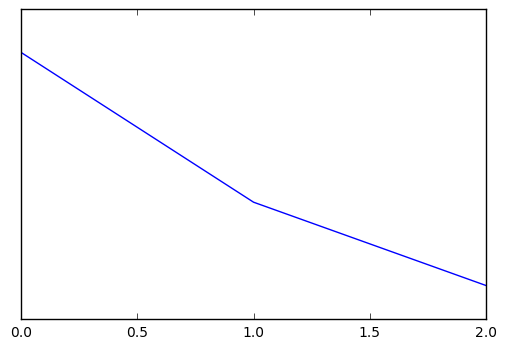

In [123]:
plt.plot(best_err_list)
plt.yticks([], [])
plt.show()

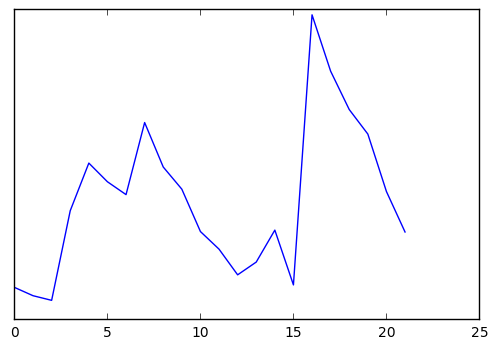

In [124]:
plt.plot(search_err_list)
plt.yticks([], [])
plt.show()

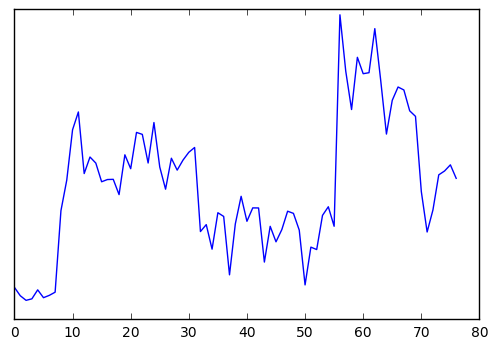

In [125]:
plt.plot(cur_err_list)
plt.yticks([], [])
plt.show()

In [126]:
print linprog_count

42900
